In [1]:
import random

random_seed = 10
random.seed(random_seed)

In [2]:
!pip install plsa

In [3]:
!pip install gensim

In [4]:
#import modules
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import nltk
from nltk.corpus import stopwords
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models import TfidfModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [5]:
# Code partially sourced from: https://github.com/yedivanseven/PLSA/blob/master/notebooks/Examples.ipynb
# Documentation: https://probabilistic-latent-semantic-analysis.readthedocs.io/en/latest/

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA


from google.colab import drive
drive.mount('/content/gdrive')

#grievances_df = pd.read_csv('/content/gdrive/MyDrive/DSSI/Palm_Oil_Grievances/Data/palm_oil_grievance_logs.csv')

#shared drive version at everyone can set up
grievances_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
grievances_df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     /usr/local/lib/python3.11/dist-
[nltk_data]     packages/plsa/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /usr/local/lib/python3.11/dist-
[nltk_data]     packages/plsa/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/lib/python3.11/dist-
[nltk_data]     packages/plsa/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/lib/python3.11/dist-
[nltk_data]     packages/plsa/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/gdrive


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


# LSA Model Creation Functions

## load_data_from_dataframe

In [6]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

## preprocess_data

In [7]:
# Add custom stopwords
# No lemmetization

stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

from nltk.corpus import stopwords
stop = set(stopwords.words('english') + stopwords_extra)
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop]

def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    #en_stop = set(stopwords.words('english') + stopwords_extra)
    en_stop = set(stopwords.words('english') + stopwords_extra)

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        print(i)
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts


In [8]:
pipeline = Pipeline(*DEFAULT_PIPELINE, remove_stopwords)
custom_pipeline = [step for step in DEFAULT_PIPELINE if step.__class__.__name__ != "LemmatizeWords"]
pipeline = Pipeline(*custom_pipeline, remove_stopwords)
pipeline

Pipeline:
0: remove_non_ascii
1: to_lower
2: remove_numbers
3: tag_remover
4: punctuation_remover
5: tokenize
6: RemoveStopwords
7: short_word_remover
8: remove_stopwords

In [9]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [10]:
grievances_summary = grievances_df['summary'].dropna().reset_index(drop=True)
grievances_summary.name = 'text'
grievances_summary.to_csv('summary.csv', index=False)
corpus = Corpus.from_csv('/content/summary.csv', pipeline)
# corpus_list = list(corpus)  # Convert the iterator to a list - This line caused the error
# print(f'Total documents in corpus: {len(corpus_list)}') # This line also caused the error
# You might want to work with corpus_list from now on if you need to access documents multiple times
corpus # Keep this line if you still want to display the corpus object representation

Corpus:
Number of documents: 387
Number of words:     3716

In [11]:
n_topics = 7

plsa = PLSA(corpus, n_topics, True)
plsa

PLSA:
====
Number of topics:     7
Number of documents:  387
Number of words:      3716
Number of iterations: 0

In [12]:
result = plsa.fit()
plsa


PLSA:
====
Number of topics:     7
Number of documents:  387
Number of words:      3716
Number of iterations: 90

In [13]:
result = plsa.best_of(10)
result

PlsaResult:
Number of topics:    7
Number of documents: 387
Number of words:     3716

In [14]:
result.topic

array([0.17073096, 0.15635265, 0.15578356, 0.14112546, 0.13375705,
       0.12501337, 0.11723695])

In [15]:
result.word_given_topic

((('mighty', 0.012786439280560207),
  ('earth', 0.012511940382024926),
  ('rapid', 0.012022309043122348),
  ('response', 0.011379652477482034),
  ('deforestation', 0.010204026188609184),
  ('indications', 0.009994774845013828),
  ('concession', 0.009636756147798785),
  ('gar', 0.008936298046758774),
  ('inside', 0.0066043136888321256),
  ('total', 0.006390134143137325),
  ('leuser', 0.0059967327111537525),
  ('agro', 0.0056930408601093075),
  ('forest', 0.005676802642829068),
  ('clearance', 0.0055518982796457636),
  ('ran', 0.005251299223948601),
  ('cleared', 0.005213018265804819),
  ('workers', 0.004924739222463789),
  ('hectares', 0.0048189827108551355),
  ('linked', 0.004725110323368602),
  ('mitra', 0.004719321523429136),
  ('june', 0.004594466189705924),
  ('ecosystem', 0.004574634580948787),
  ('kalimantan', 0.0043505053010707995),
  ('sep', 0.004339023835747454),
  ('internal', 0.004320184484328013),
  ('area', 0.004243442494969545),
  ('singkil', 0.004231407184122416),
  ('ra

In [16]:
result.tf_idf

True

In [17]:
for x in range(0,7):
  print(f"Topic {x}:")
  print(result.word_given_topic[x][:10]) # First 10 words of topic x)


Topic 0:
(('mighty', 0.012786439280560207), ('earth', 0.012511940382024926), ('rapid', 0.012022309043122348), ('response', 0.011379652477482034), ('deforestation', 0.010204026188609184), ('indications', 0.009994774845013828), ('concession', 0.009636756147798785), ('gar', 0.008936298046758774), ('inside', 0.0066043136888321256), ('total', 0.006390134143137325))
Topic 1:
(('land', 0.006414476798964401), ('nagari', 0.005838812088722223), ('communities', 0.005299326642261849), ('member', 0.005057147665062897), ('complaints', 0.004194446367557651), ('area', 0.004164618647302185), ('bumitama', 0.004158477440077275), ('submitted', 0.004059958896428899), ('fire', 0.004035130694638624), ('php', 0.003964477319002766))
Topic 2:
(('workers', 0.00587437152342021), ('rspos', 0.00580820929932117), ('ioi', 0.005547910968161374), ('principle', 0.005151631612808755), ('land', 0.003944774813471687), ('rights', 0.003461591898552732), ('procedures', 0.0033882310052214017), ('gloria', 0.003315800004306565),

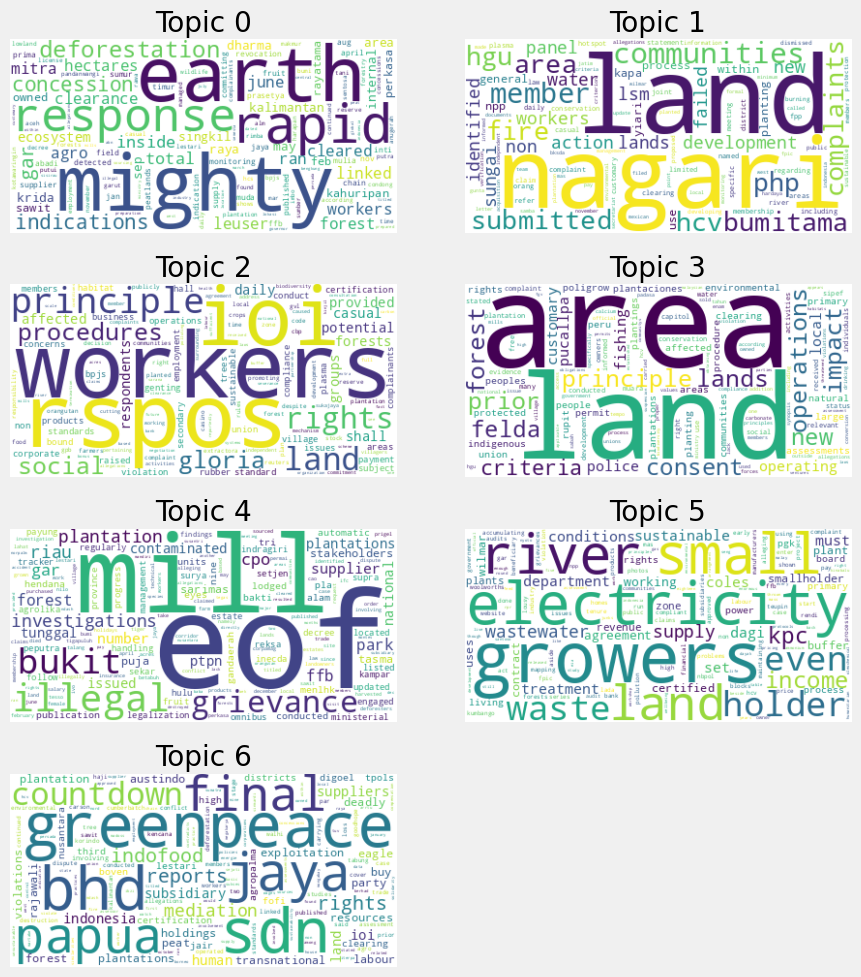

In [18]:
visualize = Visualize(result)
visualize

fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)

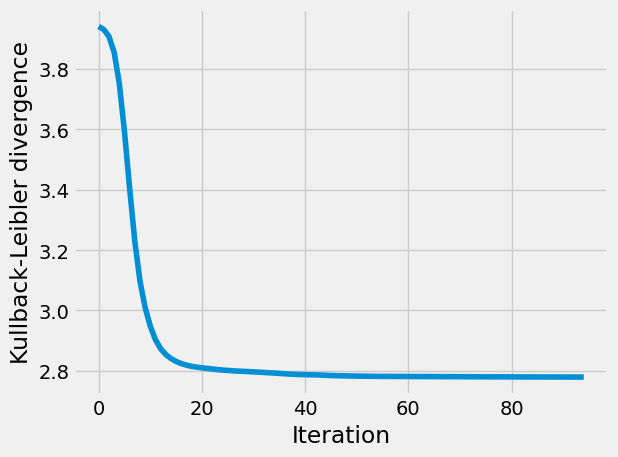

In [19]:
# this divergence measures how much information is lost when using Q to approximate P.

fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

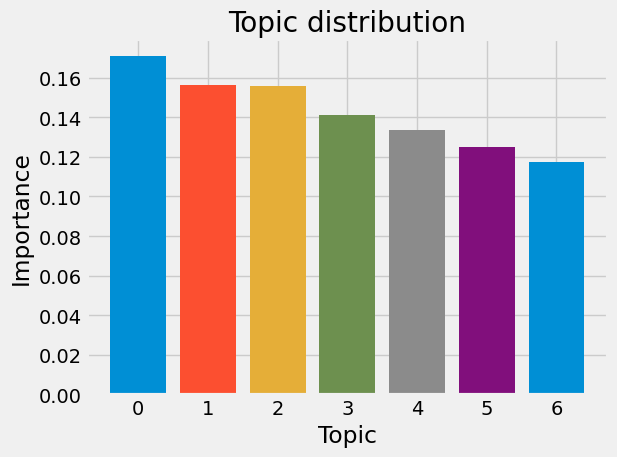

In [20]:
fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()

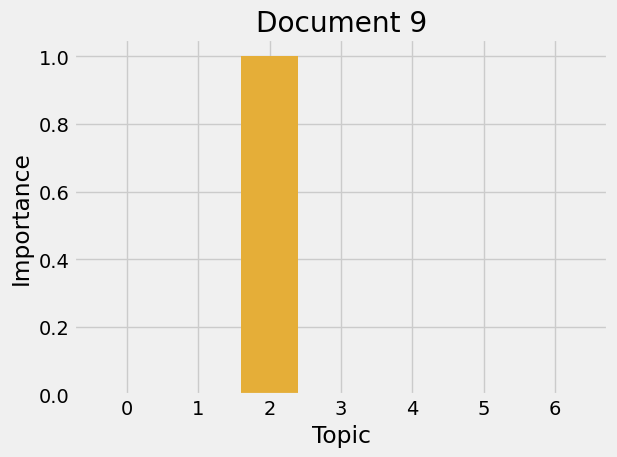

In [21]:
fig, ax = plt.subplots()
_ = visualize.topics_in_doc(9, ax) # change int to change doc
fig.tight_layout()

In [22]:
result.topic_given_doc[2]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.41380126e-05,
       9.99985862e-01, 0.00000000e+00, 0.00000000e+00])

In [23]:
type(result)

plsa.algorithms.result.PlsaResult

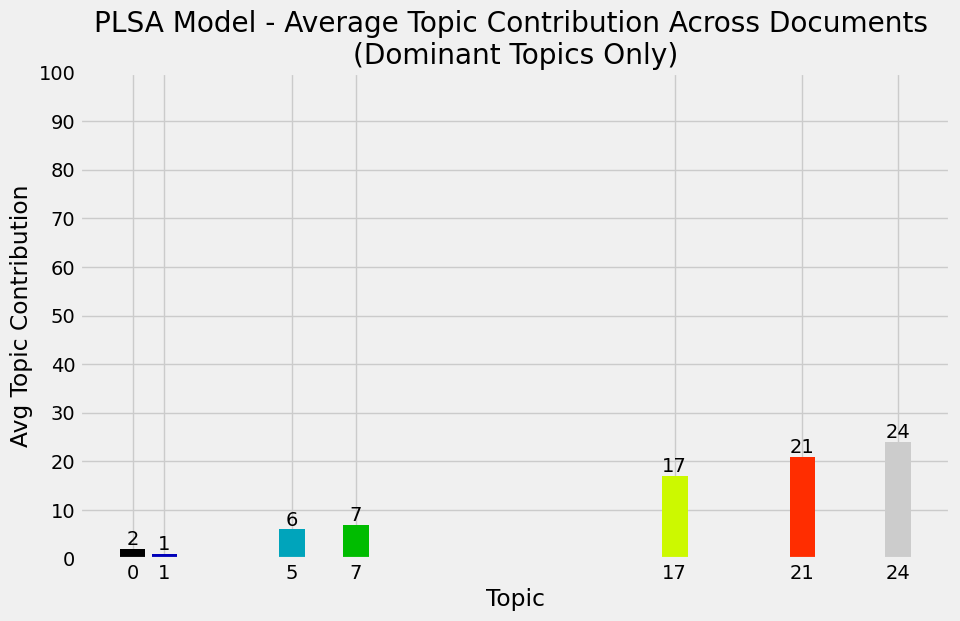

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib as it's used for plotting

# Create DataFrame for topic distribution per document
topic_given_doc_df = pd.DataFrame(result.topic_given_doc)
topic_given_doc_df = topic_given_doc_df.T  # Shape: (n_docs, n_topics)
topic_given_doc_df['Dominant_Topic'] = topic_given_doc_df.idxmax(axis=1)
topic_given_doc_df['Document'] = range(len(topic_given_doc_df))

# Prepare data for plotting average topic contribution
# Create the dominant_topic_df by selecting the dominant topic and its percentage contribution for each document
dominant_topic_df = pd.DataFrame({
    'Document': topic_given_doc_df['Document'],
    'Dominant_Topic': topic_given_doc_df['Dominant_Topic'],
    'Topic_Perc_Contribution': topic_given_doc_df.max(axis=1) # Assuming the max value is the contribution of the dominant topic
})

topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Topic_Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Topic_Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Define model_name
model_name = 'PLSA Model'

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

In [25]:

import pandas as pd
import numpy as np

# Create DataFrame for topic distribution per document
topic_given_doc_df = pd.DataFrame(result.topic_given_doc)
topic_given_doc_df = topic_given_doc_df.T  # Shape: (n_docs, n_topics)
topic_given_doc_df['Dominant_Topic'] = topic_given_doc_df.idxmax(axis=1)
topic_given_doc_df['Document'] = range(len(topic_given_doc_df))
topic_given_doc_df.head()


,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,Dominant_Topic,Document
0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.603982e-10,0.0,0.0,0.0,...,0.304753,0.0,0.0,0.0,0.000004,0.000030,0.323138,0.000003,21,0
1,0.0,1.0,0.000000,0.0,0.000000,0.0,0.000000e+00,0.0,0.0,0.0,...,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1,1
2,1.0,0.0,0.000000,1.0,0.510905,0.0,0.000000e+00,0.0,0.0,1.0,...,0.695247,1.0,0.0,0.0,0.000000,0.666529,0.676862,0.682812,0,2
3,0.0,0.0,0.000014,0.0,0.489095,0.0,1.000000e+00,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,17,3
4,0.0,0.0,0.999986,0.0,0.000000,0.0,0.000000e+00,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,7,4


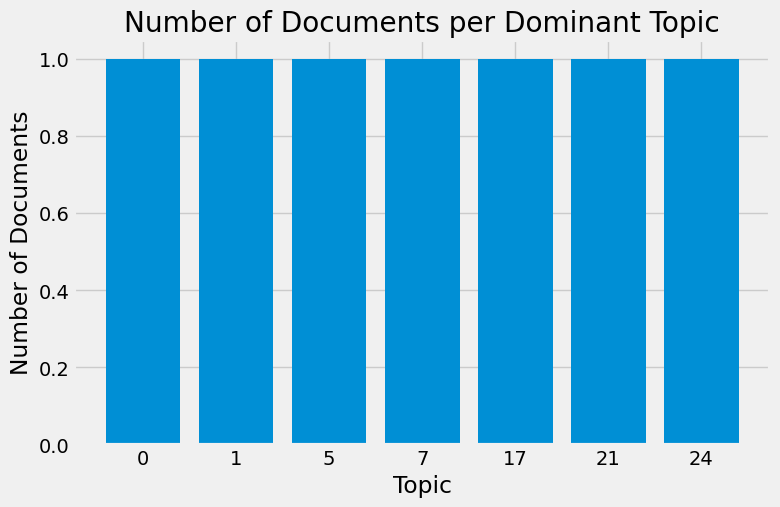

In [26]:

# Bar chart of document count per dominant topic
import matplotlib.pyplot as plt

dominant_topic_counts = topic_given_doc_df['Dominant_Topic'].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.bar(dominant_topic_counts.index.astype(str), dominant_topic_counts.values)
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Number of Documents per Dominant Topic')
plt.show()


In [27]:

# Generate word clouds per topic
from wordcloud import WordCloud

for topic_idx in range(result.topic.shape[0]):
    topic_words = result.topic[topic_idx]
    word_freq = {word: weight for word, weight in zip(corpus.vocabulary, topic_words)}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic {topic_idx}")
    plt.show()


TypeError: 'numpy.float64' object is not iterable